# Libraries

In [1]:
!pip install deepxde


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 4.4 MB/s eta 0:00:00


# PINNs (Classic Activations - Tanh and Sigmoid)

## 1D Poisson Equation with Dirichlet Boundary Condition

In [2]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)

def boundary(x, on_boundary):
    return on_boundary

def func(x):
    return np.sin(np.pi * x)

geom = dde.geometry.Interval(-1, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]
initializer = "Glorot uniform"

def train_model(activation):
    net = dde.nn.FNN(layer_size, activation, initializer)
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    losshistory, train_state = model.train(iterations=10000)
    return model, losshistory, train_state

model_tanh, _, _ = train_model("tanh")
model_sigmoid, _, _ = train_model("sigmoid")

# Generate points for prediction
x = geom.uniform_points(1000, True)
y_true = func(x)
y_pred_tanh = model_tanh.predict(x)
y_pred_sigmoid = model_sigmoid.predict(x)


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.130771 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.736406 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.49e+01, 1.93e-01]    [5.07e+01, 1.93e-01]    [1.32e+00]    
1000      [2.32e-04, 1.30e-07]    [2.79e-04, 1.30e-07]    [3.07e-04]    
2000      [1.90e-05, 2.19e-09]    [5.79e-05, 2.19e-09]    [8.60e-05]    
3000      [1.19e-05, 4.01e-10]    [4.69e-05, 4.01e-10]    [6.30e-05]    
4000      [1.16e-05, 8.89e-08]    [4.48e-05, 8.89e-08]    [2.16e-04]    
5000      [1.03e-05, 1.51e-07]    [4.62e-05, 1.51e-07]    [2.91e-04]    
6000      [1.12e-05, 9.81e-08]    [4.41e-05, 9.81e-08]    [3.73e-04]    
7000      [1.27e-03, 5.52e-05]    [9.12e-04, 5.52e-05]    [5.90e-03]    
8000      [2.39e-04, 4.79e-06]    [3.26e-04, 4.79e-06]    [2.17e-03]    
9000      [2.11e-04, 1.32e-05]    [1.68e-04, 1.32e-05]    [3.00e-03]    
10000     [1.81e-05, 2.22e-06]    [4.37e-05, 2.22e-06]    [1.61e-03]    

Best model at step 5000:
  train loss: 1.05e-05
  test loss: 4.63e-05
  test 

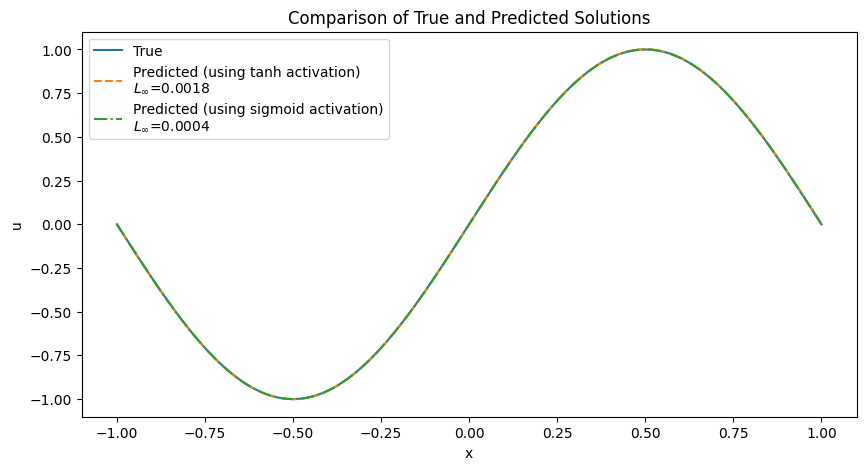

In [3]:
# Calculate L_infinity norms
l_inf_tanh = np.max(np.abs(y_true - y_pred_tanh))
l_inf_sigmoid = np.max(np.abs(y_true - y_pred_sigmoid))

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x, y_true, label='True')
plt.plot(x, y_pred_tanh, label=f'Predicted (using tanh activation)\n$L_{{\infty}}$={l_inf_tanh:.4f}', linestyle='--')
plt.plot(x, y_pred_sigmoid, label=f'Predicted (using sigmoid activation)\n$L_{{\infty}}$={l_inf_sigmoid:.4f}', linestyle='-.')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Comparison of True and Predicted Solutions')
plt.legend()
plt.savefig('poisson_ca_plot.pdf')  # Save the plot as a PDF
plt.show()


## 1D Burgers' Equation

In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt

# Define the true solution
def true_solution(x):
    t = x[:, 1:2]
    x = x[:, 0:1]
    return 2 * x / (1 + 2 * t)

# Define the PDE
def pde(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    u_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_xx = dde.grad.hessian(u, x, i=0, j=0)
    return u_t + u * u_x - u_xx

# Geometry and time domain
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial condition
def initial_cond(x):
    return 2 * x[:, 0:1]

ic = dde.icbc.IC(geomtime, initial_cond, lambda _, on_initial: on_initial)

# Create the data object
data = dde.data.TimePDE(
    geomtime,
    pde,
    ic,
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=10000,
    solution=true_solution
)

# Function to train the model with different activation functions
def train_model(activation):
    net = dde.maps.FNN([2] + [32] * 3 + [1], activation, "Glorot normal")
    model = dde.Model(data, net)
    model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
    model.train(epochs=5000)
    return model

# Train models with tanh and sigmoid activations
model_tanh = train_model("tanh")
model_sigmoid = train_model("sigmoid")

# Generate test data
x_test = data.test_x

# Predict solutions
y_true = true_solution(x_test)
y_pred_tanh = model_tanh.predict(x_test)
y_pred_sigmoid = model_sigmoid.predict(x_test)

Compiling model...
Building feed-forward neural network...
'build' took 0.075767 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.401599 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [8.44e-02, 1.53e+00]    [8.26e-02, 1.53e+00]    [1.25e+00]    
1000      [1.80e-04, 6.04e-04]    [9.91e-05, 6.04e-04]    [3.41e-01]    
2000      [5.15e-05, 6.09e-05]    [2.40e-05, 6.09e-05]    [1.89e-01]    
3000      [2.27e-05, 1.53e-05]    [1.37e-05, 1.53e-05]    [1.47e-01]    
4000      [6.66e-05, 1.96e-05]    [5.56e-05, 1.96e-05]    [1.36e-01]    
5000      [5.30e-06, 1.06e-05]    [3.57e-06, 1.06e-05]    [1.25e-01]    

Best model at step 5000:
  train loss: 1.59e-05
  test loss: 1.42e-05
  test metric: [1.25e-01]

'train' took 75.034327 s

Compiling model...
Building feed-forward neural network...
'build' took 0.074573 s

'compile' took 1.361643 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [2.19e-06, 2.15e+00]    [2.18e-06, 2.15e+00]    [1.47e+00]    
1000      [1.12e-02, 2.32e-02]    [6.86e-03

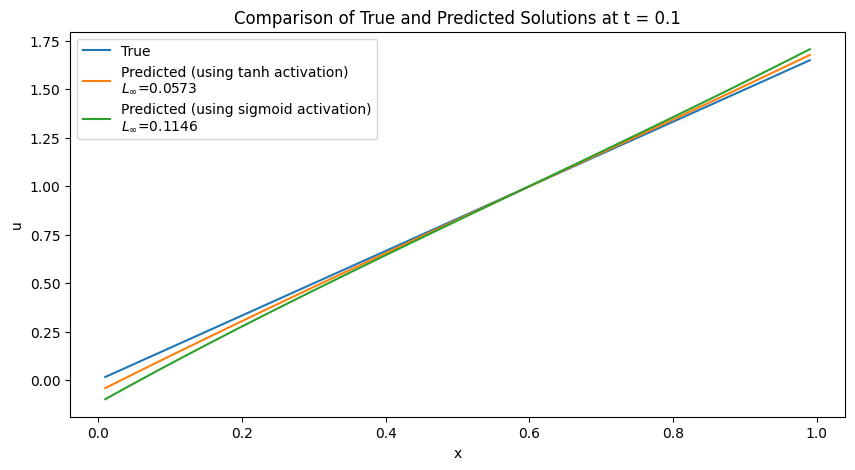

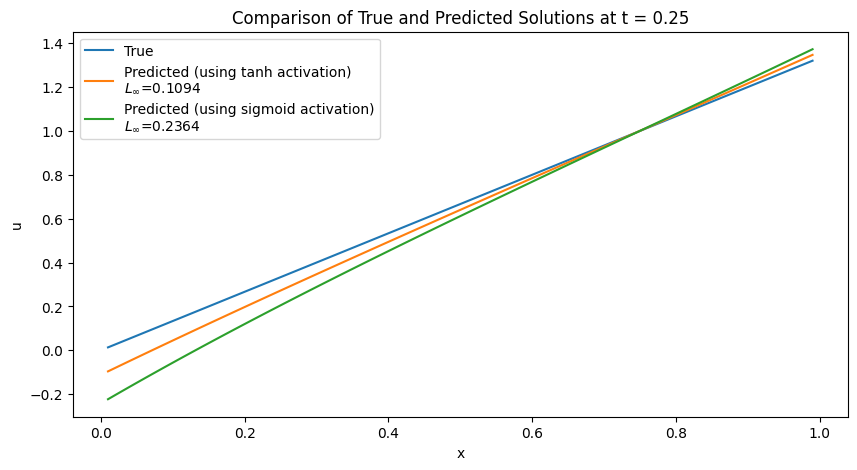

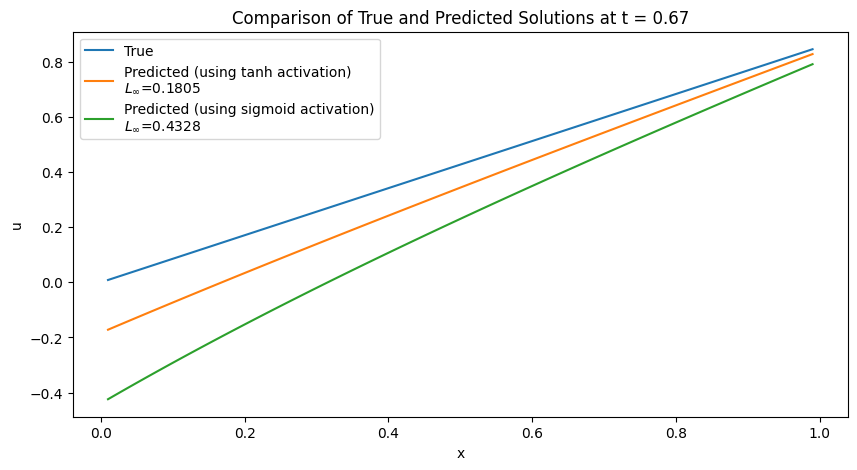

In [ ]:
# Plot results for specific time points
def plot_results(t_values):
    for t in t_values:
        mask = np.isclose(x_test[:, 1], t)
        x_plot = x_test[mask][:, 0]
        y_true_plot = y_true[mask]
        y_pred_tanh_plot = y_pred_tanh[mask]
        y_pred_sigmoid_plot = y_pred_sigmoid[mask]

        # Calculate L_infinity norms
        l_inf_tanh = np.max(np.abs(y_true_plot - y_pred_tanh_plot))
        l_inf_sigmoid = np.max(np.abs(y_true_plot - y_pred_sigmoid_plot))

        plt.figure(figsize=(10, 5))
        plt.plot(x_plot, y_true_plot, label='True')
        plt.plot(x_plot, y_pred_tanh_plot, label=f'Predicted (using tanh activation)\n$L_{{\infty}}$={l_inf_tanh:.4f}')
        plt.plot(x_plot, y_pred_sigmoid_plot, label=f'Predicted (using sigmoid activation)\n$L_{{\infty}}$={l_inf_sigmoid:.4f}')
        plt.xlabel('x')
        plt.ylabel('u')
        plt.title(f'Comparison of True and Predicted Solutions at t = {t}')
        plt.legend()
        plt.savefig(f'burger_ca_plot_t_{t}.pdf')
        plt.show()

# Plot results for t = 0.1, 0.25, 0.67
plot_results([0.1, 0.25, 0.67])

## 2D Heat Equation

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def heat_eq_exact_solution(x, t):
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)


def gen_exact_solution():
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.0)
    x_max, t_max = (L, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)


def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the exact solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

# Generate a dataset with the exact solution (if you don't have one):
gen_exact_solution()


def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=400,
    num_boundary=80,
    num_initial=160,
    num_test=400,
)

def build_and_train_model(activation):
    net = dde.nn.FNN([2] + [20] * 2 + [1], activation, "Glorot normal")
    model = dde.Model(data, net)
    model.compile("adam", lr=0.01)
    model.train(iterations=5000)
    return model

# Train models with different activations and gather predictions
model_tanh = build_and_train_model("tanh")
model_sigmoid = build_and_train_model("sigmoid")

# Generate test data
X, y_true = gen_testdata()

# Get predictions
y_pred_tanh = model_tanh.predict(X).flatten()
y_pred_sigmoid = model_sigmoid.predict(X).flatten()


<ipython-input-4-ca21c19f9486>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  usol[i][j] = heat_eq_exact_solution(x[i], t[j])


Compiling model...
Building feed-forward neural network...
'build' took 0.067643 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.675175 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.69e-02, 1.43e-01, 2.19e-01]    [6.37e-02, 1.43e-01, 2.19e-01]    []  
1000      [3.56e-03, 4.99e-04, 5.19e-04]    [2.85e-03, 4.99e-04, 5.19e-04]    []  
2000      [3.14e-04, 3.46e-05, 6.72e-05]    [2.78e-04, 3.46e-05, 6.72e-05]    []  
3000      [1.89e-04, 1.42e-05, 3.07e-05]    [1.69e-04, 1.42e-05, 3.07e-05]    []  
4000      [1.47e-04, 1.58e-05, 2.95e-05]    [1.21e-04, 1.58e-05, 2.95e-05]    []  
5000      [1.54e-04, 4.50e-05, 4.21e-05]    [9.39e-05, 4.50e-05, 4.21e-05]    []  

Best model at step 4000:
  train loss: 1.93e-04
  test loss: 1.67e-04
  test metric: []

'train' took 10.084560 s

Compiling model...
Building feed-forward neural network...
'build' took 0.074714 s

'compile' took 0.644756 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.89e-03, 6.61e-01,

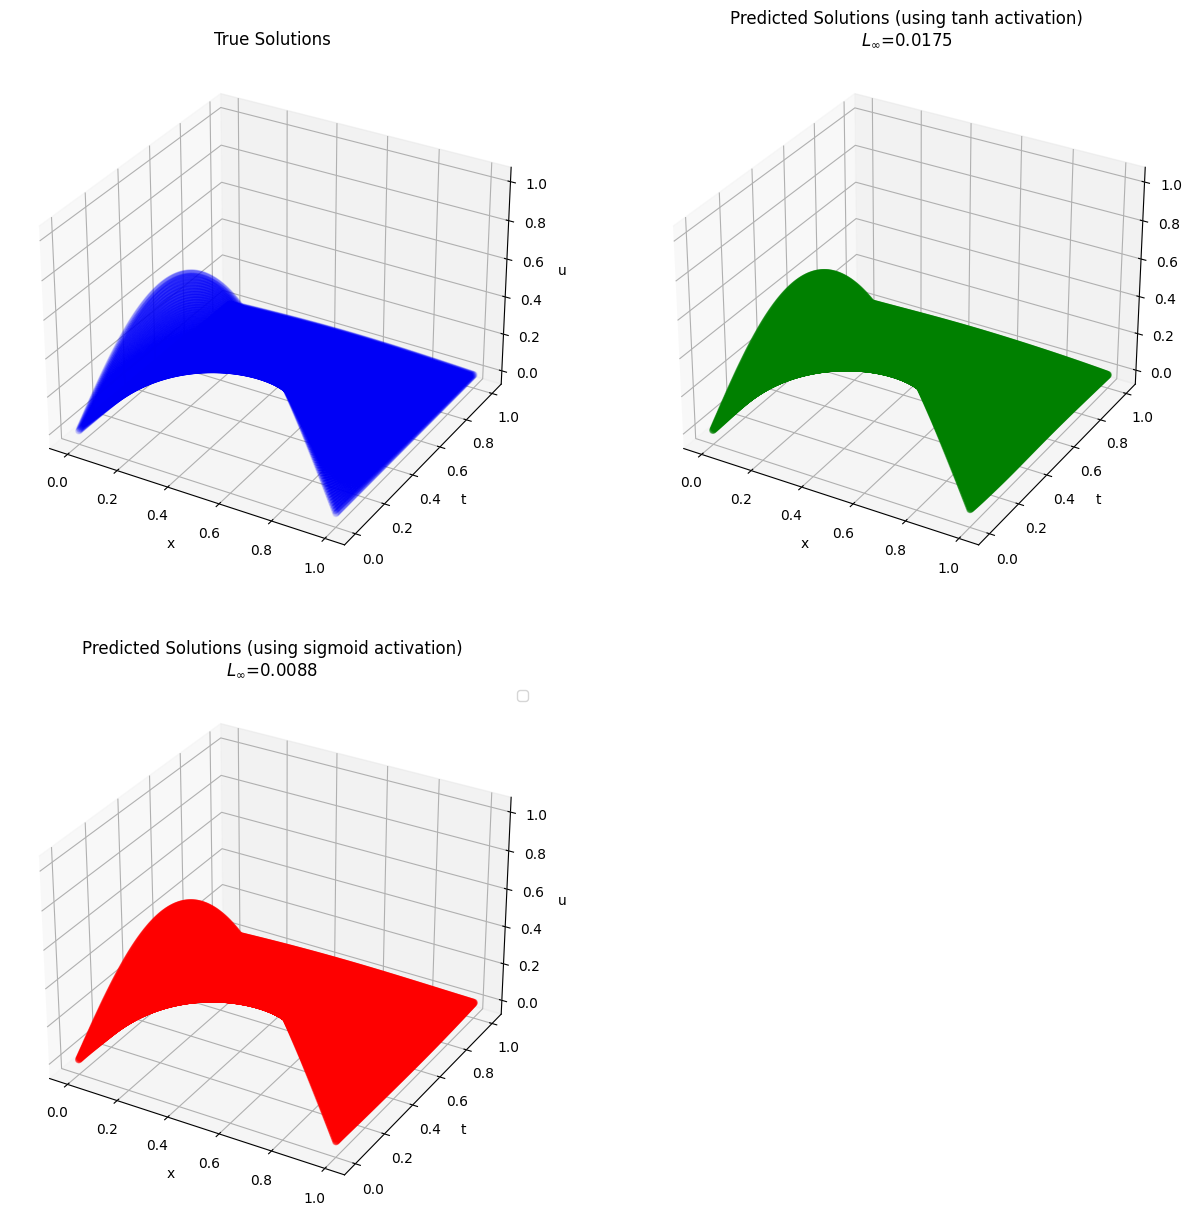

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_results(x, y_true, y_pred_tanh, y_pred_sigmoid):
    fig = plt.figure(figsize=(15, 15))

    # Compute L_infinity norms
    linf_tanh = np.max(np.abs(y_true - y_pred_tanh))
    linf_sigmoid = np.max(np.abs(y_true - y_pred_sigmoid))

    # Plot true solutions
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], y_true, c='blue', marker='o', alpha=0.1)
    ax1.set_title('True Solutions')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('u')

    # Plot predicted solutions with tanh activation
    ax2 = fig.add_subplot(222, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], y_pred_tanh, c='green', marker='o', alpha=0.5)
    ax2.set_title(f'Predicted Solutions (using tanh activation)\n$L_{{\infty}}$={linf_tanh:.4f}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    ax2.set_zlabel('u')

    # Plot predicted solutions with sigmoid activation
    ax3 = fig.add_subplot(223, projection='3d')
    ax3.scatter(x[:, 0], x[:, 1], y_pred_sigmoid, c='red', marker='o', alpha=0.5)
    ax3.set_title(f'Predicted Solutions (using sigmoid activation)\n$L_{{\infty}}$={linf_sigmoid:.4f}')
    ax3.set_xlabel('x')
    ax3.set_ylabel('t')
    ax3.set_zlabel('u')

    # Save each subplot as a separate image
    plt.savefig('heat_ca_plot.png')
    plt.legend()
    plt.show()

plot_3d_results(X, y_true.flatten(), y_pred_tanh, y_pred_sigmoid)


## 2D Helmhotz Equation

In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# General parameters
n = 2
precision_train = 10
precision_test = 30
hard_constraint = True
weights = 100  # if hard_constraint == False
iterations = 5000
learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 150

# Define sine function
sin = dde.backend.sin
k0 = 2 * np.pi * n

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    if dde.backend.backend_name == "jax":
        y = y[0]
        dy_xx = dy_xx[0]
        dy_yy = dy_yy[0]

    f = k0**2 * sin(k0 * x[:, 0:1]) * sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0**2 * y - f

def func(x):
    return np.sin(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2])

def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y

def boundary(_, on_boundary):
    return on_boundary

geom = dde.geometry.Rectangle([0, 0], [1, 1])
wave_len = 1 / n

hx_train = wave_len / precision_train
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

if hard_constraint == True:
    bc = []
else:
    bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=nx_train**2,
    num_boundary=4 * nx_train,
    solution=func,
    num_test=nx_test**2,
)

# Function to train the model with different activation functions
def train_model(activation):
    net = dde.nn.FNN([2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform")
    if hard_constraint == True:
        net.apply_output_transform(transform)
    model = dde.Model(data, net)
    if hard_constraint == True:
        model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
    else:
        loss_weights = [1, weights]
        model.compile("adam", lr=learning_rate, metrics=["l2 relative error"], loss_weights=loss_weights)
    model.train(iterations=iterations)
    return model

model_tanh = train_model("tanh")
model_sigmoid = train_model("sigmoid")

# Generate test data
x_test = data.test_x

# Predict solutions
y_true = func(x_test)
y_pred_tanh = model_tanh.predict(x_test)
y_pred_sigmoid = model_sigmoid.predict(x_test)



Compiling model...
Building feed-forward neural network...
'build' took 0.119385 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.967863 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.21e+03]    [6.44e+03]    [1.00e+00]    
1000      [9.80e+02]    [1.15e+04]    [9.84e-01]    
2000      [6.58e+02]    [1.66e+04]    [9.64e-01]    
3000      [5.34e+02]    [1.96e+04]    [9.63e-01]    
4000      [4.73e+02]    [2.27e+04]    [9.90e-01]    
5000      [3.84e+02]    [2.54e+04]    [1.02e+00]    

Best model at step 5000:
  train loss: 3.84e+02
  test loss: 2.54e+04
  test metric: [1.02e+00]

'train' took 158.733560 s

Compiling model...
Building feed-forward neural network...
'build' took 0.097296 s

'compile' took 3.385102 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.23e+03]    [6.47e+03]    [1.00e+00]    
1000      [5.21e+03]    [6.44e+03]    [1.00e+00]    
2000      [5.21e+03]    [6.44e+03]    [1.00e+00]    
3000      [5.21e+03]    [6.44e+03]    [1.00e+00]    
4000      [3.08e+03]    [4.61e+03]    [9.79e-01]    
5000      

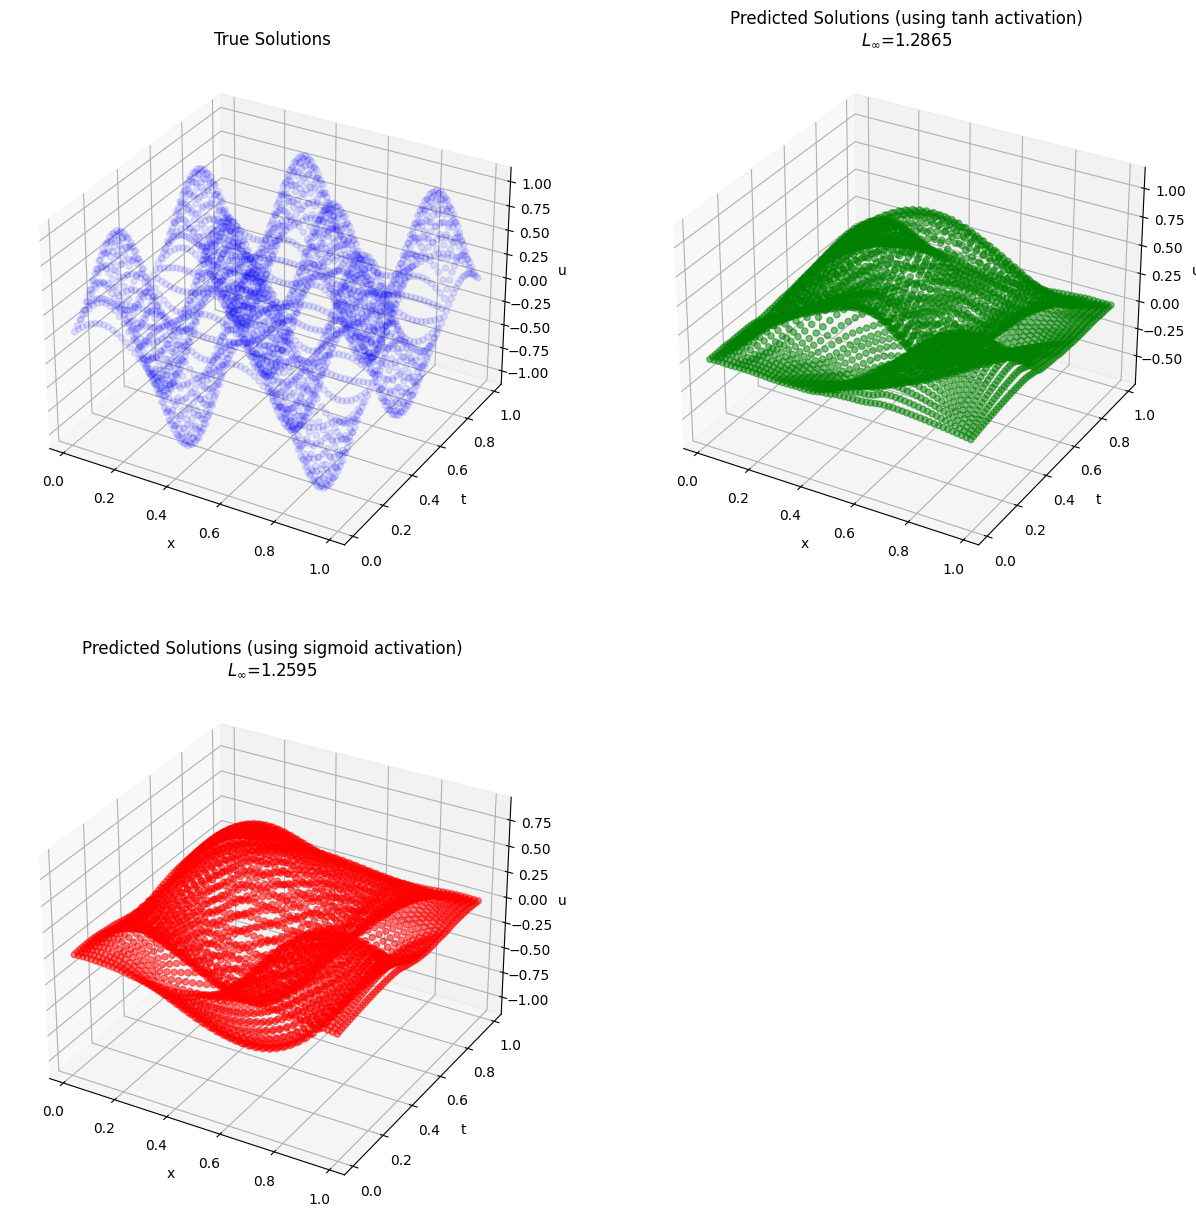

In [ ]:
# Plot 3D results for x, y vs u
def plot_3d_results(x, y_true, y_pred_tanh, y_pred_sigmoid):
    fig = plt.figure(figsize=(15, 15))

    # Compute L_infinity norms
    linf_tanh = np.max(np.abs(y_true - y_pred_tanh))
    linf_sigmoid = np.max(np.abs(y_true - y_pred_sigmoid))

    # Plot true solutions
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], y_true, c='blue', marker='o', alpha=0.1)
    ax1.set_title('True Solutions')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('u')

    # Plot predicted solutions with tanh activation
    ax2 = fig.add_subplot(222, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], y_pred_tanh, c='green', marker='o', alpha=0.5)
    ax2.set_title(f'Predicted Solutions (using tanh activation)\n$L_{{\infty}}$={linf_tanh:.4f}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    ax2.set_zlabel('u')

    # Plot predicted solutions with sigmoid activation
    ax3 = fig.add_subplot(223, projection='3d')
    ax3.scatter(x[:, 0], x[:, 1], y_pred_sigmoid, c='red', marker='o', alpha=0.5)
    ax3.set_title(f'Predicted Solutions (using sigmoid activation)\n$L_{{\infty}}$={linf_sigmoid:.4f}')
    ax3.set_xlabel('x')
    ax3.set_ylabel('t')
    ax3.set_zlabel('u')

    # Save each subplot as a separate image
    ax1.figure.savefig('helmholtz_true_plot.pdf')
    ax2.figure.savefig('helmholtz_tanh_plot.pdf')
    ax3.figure.savefig('helmholtz_sigmoid_plot.pdf')

    plt.show()

plot_3d_results(x_test, y_true, y_pred_tanh, y_pred_sigmoid)

## 2D Elastostatic Equation

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

lmbd = 1.0
mu = 0.5
Q = 4.0

# Define functions
sin = dde.backend.sin
cos = dde.backend.cos
stack = dde.backend.stack

geom = dde.geometry.Rectangle([0, 0], [1, 1])
BC_type = ["hard", "soft"][0]

def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1.0)

def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1.0)

def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)

# Exact solutions
def func(x):
    ux = np.cos(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    uy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4

    E_xx = -2 * np.pi * np.sin(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    E_yy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 3
    E_xy = 0.5 * (
        np.pi * np.cos(2 * np.pi * x[:, 0:1]) * np.cos(np.pi * x[:, 1:2])
        + np.pi * np.cos(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4
    )

    Sxx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    Syy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    Sxy = 2 * E_xy * mu

    return np.hstack((ux, uy, Sxx, Syy, Sxy))

# Soft Boundary Conditions
ux_top_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_top, component=0)
ux_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
uy_left_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=1)
uy_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
uy_right_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_right, component=1)
sxx_left_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=2)
sxx_right_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_right, component=2)
syy_top_bc = dde.icbc.DirichletBC(
    geom,
    lambda x: (2 * mu + lmbd) * Q * np.sin(np.pi * x[:, 0:1]),
    boundary_top,
    component=3,
)

# Hard Boundary Conditions
def hard_BC(x, f):
    Ux = f[:, 0] * x[:, 1] * (1 - x[:, 1])
    Uy = f[:, 1] * x[:, 0] * (1 - x[:, 0]) * x[:, 1]

    Sxx = f[:, 2] * x[:, 0] * (1 - x[:, 0])
    Syy = f[:, 3] * (1 - x[:, 1]) + (lmbd + 2 * mu) * Q * sin(np.pi * x[:, 0])
    Sxy = f[:, 4]
    return stack((Ux, Uy, Sxx, Syy, Sxy), axis=1)

def fx(x):
    return (
        -lmbd
        * (
            4 * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
            - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1])
        )
        - mu
        * (
            np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
            - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1])
        )
        - 8 * mu * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
    )

def fy(x):
    return (
        lmbd
        * (
            3 * Q * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
            - 2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
        )
        - mu
        * (
            2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
            + (Q * x[:, 1:2] ** 4 * np.pi**2 * sin(np.pi * x[:, 0:1])) / 4
        )
        + 6 * Q * mu * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
    )

def jacobian(f, x, i, j):
    if dde.backend.backend_name == "jax":
        return dde.grad.jacobian(f, x, i=i, j=j)[0]
    else:
        return dde.grad.jacobian(f, x, i=i, j=j)

def pde(x, f):
    E_xx = jacobian(f, x, i=0, j=0)
    E_yy = jacobian(f, x, i=1, j=1)
    E_xy = 0.5 * (jacobian(f, x, i=0, j=1) + jacobian(f, x, i=1, j=0))

    S_xx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    S_yy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    S_xy = E_xy * 2 * mu

    Sxx_x = jacobian(f, x, i=2, j=0)
    Syy_y = jacobian(f, x, i=3, j=1)
    Sxy_x = jacobian(f, x, i=4, j=0)
    Sxy_y = jacobian(f, x, i=4, j=1)

    momentum_x = Sxx_x + Sxy_y - fx(x)
    momentum_y = Sxy_x + Syy_y - fy(x)

    if dde.backend.backend_name == "jax":
        f = f[0]  # f[1] is the function used by jax to compute the gradients

    stress_x = S_xx - f[:, 2:3]
    stress_y = S_yy - f[:, 3:4]
    stress_xy = S_xy - f[:, 4:5]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]

if BC_type == "hard":
    bcs = []
else:
    bcs = [
        ux_top_bc,
        ux_bottom_bc,
        uy_left_bc,
        uy_bottom_bc,
        uy_right_bc,
        sxx_left_bc,
        sxx_right_bc,
        syy_top_bc,
    ]

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=500,
    num_boundary=500,
    solution=func,
    num_test=400,
)

def build_and_train_model(activation):
    layers = [2] + [40] * 5 + [5]
    net = dde.nn.PFNN(layers, activation, "Glorot uniform")
    if BC_type == "hard":
        net.apply_output_transform(hard_BC)

    model = dde.Model(data, net)
    if activation == "tanh":
        model.compile("adam", lr=0.009, metrics=["l2 relative error"])
    else:
        model.compile("adam", lr=0.0003, metrics=["l2 relative error"])
    model.train(iterations=5000)
    return model

# Train models with different activations and gather predictions
model_tanh = build_and_train_model("tanh")
model_sigmoid = build_and_train_model("sigmoid")

# Generate test data
X = data.test_x

y_true = func(X)

# Get predictions
y_pred_tanh = model_tanh.predict(X)
y_pred_sigmoid = model_sigmoid.predict(X)

Compiling model...
Building feed-forward neural network...
'build' took 0.190588 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.530359 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.81e+03, 2.65e+02, 4.62e-04, 2.40e+01, 8.34e-03]    [1.78e+03, 2.58e+02, 7.67e-04, 3.33e+01, 9.70e-03]    [1.13e+00]    
1000      [1.26e+00, 1.34e+00, 4.40e-01, 6.57e-01, 9.57e-01]    [2.42e+00, 9.27e-01, 3.47e-01, 8.51e-01, 1.21e+00]    [2.32e-01]    
2000      [3.61e-01, 9.49e-02, 8.12e-02, 9.14e-02, 1.27e-01]    [3.94e-01, 1.39e-01, 1.22e-01, 1.10e-01, 1.77e-01]    [8.15e-02]    
3000      [4.68e-01, 2.61e-01, 4.27e-02, 3.27e-02, 4.31e-02]    [4.03e-01, 1.99e-01, 5.95e-02, 4.06e-02, 6.03e-02]    [4.67e-02]    
4000      [2.35e-01, 1.45e-01, 2.65e-02, 1.76e-02, 2.17e-02]    [2.94e-01, 1.11e-01, 4.17e-02, 2.62e-02, 3.30e-02]    [3.71e-02]    
5000      [7.81e-01, 3.62e-01, 5.22e-02, 2.21e-02, 1.52e-02]    [1.19e+00, 3.53e-01, 7.78e-02, 2.33e-02, 2.09e-02]    [4.54e-02]    

Best model at step 400

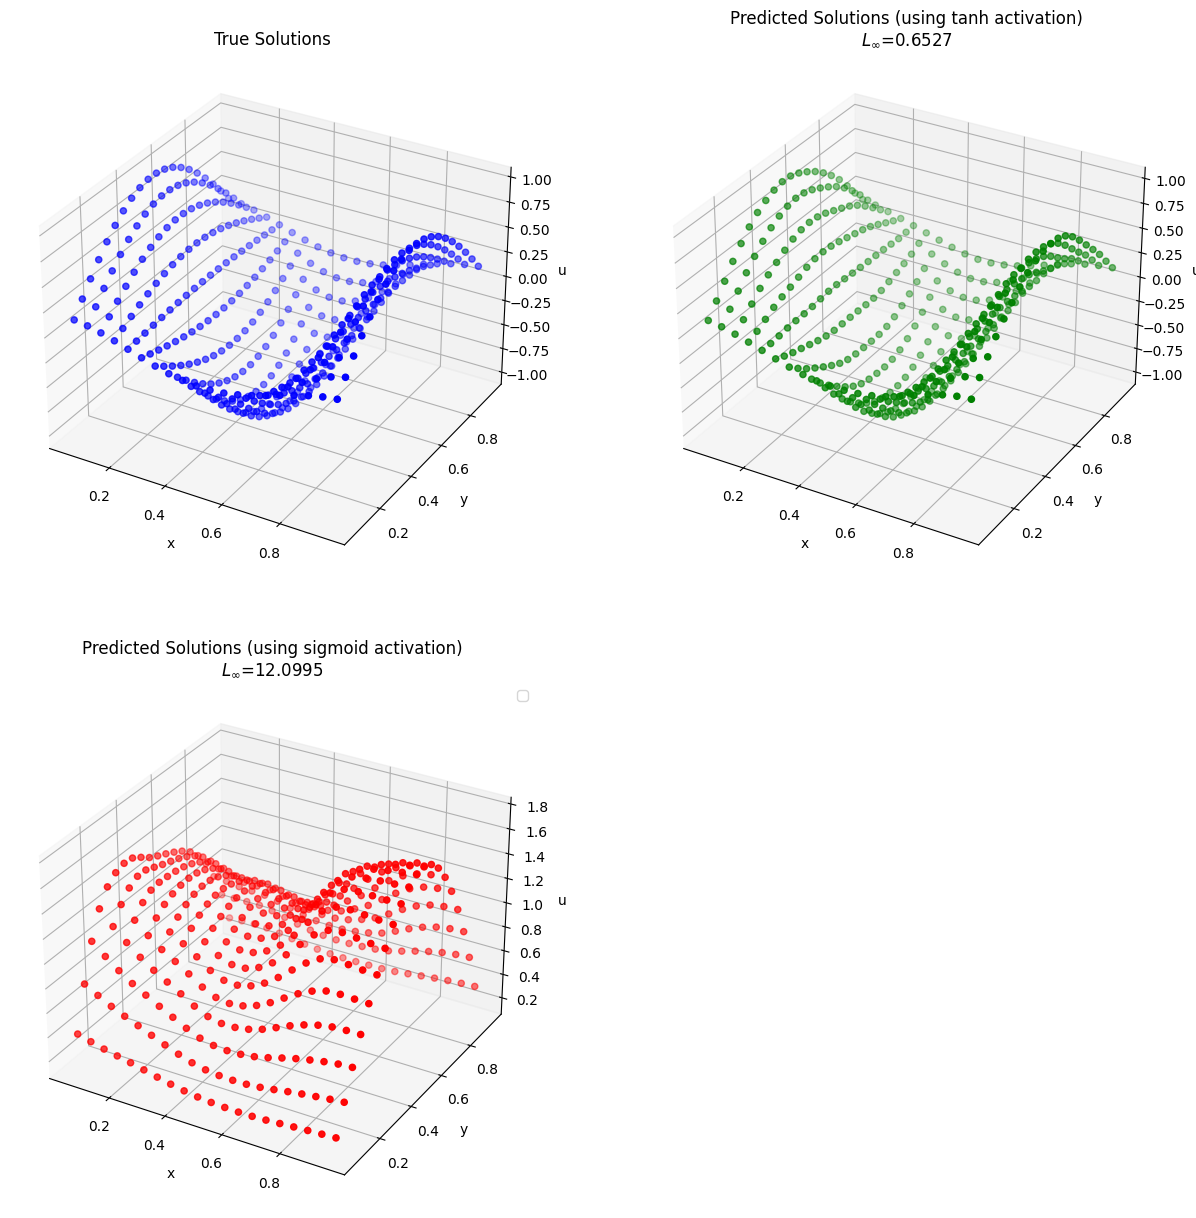

In [ ]:
def plot_3d_results(x, y_true, y_pred_tanh, y_pred_sigmoid):
    fig = plt.figure(figsize=(15, 15))

    # Calculate L_infinity norms
    l_inf_tanh = np.max(np.abs(y_true - y_pred_tanh))
    l_inf_sigmoid = np.max(np.abs(y_true - y_pred_sigmoid))

    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], y_true[:, 0], c='blue', marker='o')
    ax1.set_title('True Solutions')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('u')

    ax2 = fig.add_subplot(222, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], y_pred_tanh[:, 0], c='green', marker='o')
    ax2.set_title(f'Predicted Solutions (using tanh activation)\n$L_{{\infty}}$={l_inf_tanh:.4f}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('u')

    ax3 = fig.add_subplot(223, projection='3d')
    ax3.scatter(x[:, 0], x[:, 1], y_pred_sigmoid[:, 0], c='red', marker='o')
    ax3.set_title(f'Predicted Solutions (using sigmoid activation)\n$L_{{\infty}}$={l_inf_sigmoid:.4f}')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('u')

    ax1.figure.savefig('elastostatic_true_plot.pdf')
    ax2.figure.savefig('elastostatic_tanh_plot.pdf')
    ax3.figure.savefig('elastostatic_sigmoid_plot.pdf')

    plt.legend()
    plt.show()

plot_3d_results(X, y_true, y_pred_tanh, y_pred_sigmoid)


# PINNs (Fibonacci Sequence Based Activation)

In [4]:
import tensorflow as tf

def fibonacci_polynomial(x, degree):
    # Handle base cases
    if degree == 0:
        return tf.zeros_like(x)
    elif degree == 1:
        return x

    # Create a list to store the computed values of the Fibonacci polynomials
    fib_polys = [tf.zeros_like(x), x]

    # Compute the Fibonacci polynomials iteratively and store them in the list
    for i in range(2, degree + 1):
        fib_polys.append(x * fib_polys[i-1] + fib_polys[i-2])

    # Return the required polynomial
    return fib_polys[degree]


class FibonacciActivation(tf.keras.layers.Layer):
    def __init__(self, degree=2, **kwargs):
        super(FibonacciActivation, self).__init__(**kwargs)
        self.degree = degree

    def call(self, inputs):
        return fibonacci_polynomial(inputs, self.degree)

class AdaptiveActivation(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.alpha = tf.Variable(1.0, trainable=True)

    def call(self, inputs):
        return tf.nn.tanh(self.alpha * inputs)

## 1D Poisson Equation with Dirichlet Boundary Condition

In [5]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)

def boundary(x, on_boundary):
    return on_boundary

def func(x):
    return np.sin(np.pi * x)

geom = dde.geometry.Interval(-1, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 4 + [1]
initializer = "Glorot uniform"

# Define the neural network with fibonacci activation function
net = dde.nn.FNN(layer_size, AdaptiveActivation(), initializer)
model = dde.Model(data, net)
model.compile("adam", lr=0.0001, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=10000)

# Generate points for prediction
x = geom.uniform_points(1000, True)
y_true = func(x)
y_pred = model.predict(x)


Compiling model...
Building feed-forward neural network...
'build' took 0.121401 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.813038 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.39e+01, 1.92e-02]    [4.97e+01, 1.92e-02]    [1.10e+00]    
1000      [2.95e-02, 1.10e-03]    [1.46e-02, 1.10e-03]    [2.79e-02]    
2000      [6.37e-03, 4.78e-05]    [4.29e-03, 4.78e-05]    [5.76e-03]    
3000      [3.05e-03, 7.90e-06]    [2.50e-03, 7.90e-06]    [2.37e-03]    
4000      [8.93e-04, 1.82e-06]    [7.98e-04, 1.82e-06]    [1.13e-03]    
5000      [1.95e-04, 1.58e-07]    [2.44e-04, 1.58e-07]    [3.57e-04]    
6000      [9.49e-05, 1.00e-07]    [1.37e-04, 1.00e-07]    [2.42e-04]    
7000      [4.81e-05, 6.90e-09]    [7.62e-05, 6.90e-09]    [1.38e-04]    
8000      [2.97e-05, 7.95e-08]    [5.44e-05, 7.95e-08]    [2.53e-04]    
9000      [2.32e-05, 1.06e-07]    [3.75e-05, 1.06e-07]    [2.41e-04]    
10000     [1.77e-05, 3.87e-08]    [3.82e-05, 3.87e-08]    [1.78e-04]    

Best model at step 10000:
  train loss: 1.77e-05
  test loss: 3.83e-05
  test

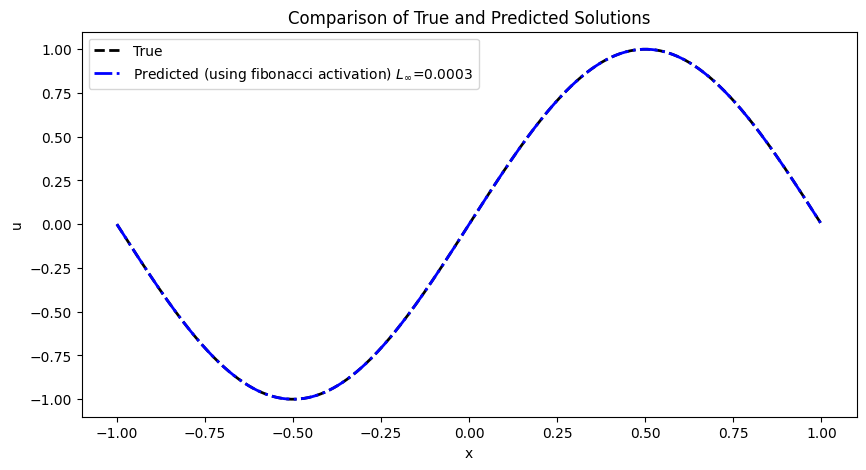

In [6]:
l_inf_error = np.max(np.abs(y_true - y_pred))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x, y_true, label="True", linestyle="--", color="black", linewidth=2)
plt.plot(x, y_pred, label=f"Predicted (using fibonacci activation) $L_{{\infty}}$={l_inf_error:.4f}", linestyle="-.", color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.title("Comparison of True and Predicted Solutions")
plt.savefig('poisson_fa_plot.pdf')
plt.show()

## 1D Burgers' Equation

In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from deepxde.backend import tf

# Define the true solution
def true_solution(x):
    t = x[:, 1:2]
    x = x[:, 0:1]
    return 2 * x / (1 + 2 * t)

# Define the PDE
def pde(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    u_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_xx = dde.grad.hessian(u, x, i=0, j=0)
    return u_t + u * u_x - u_xx

# Geometry and time domain
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial condition
def initial_cond(x):
    return 2 * x[:, 0:1]

ic = dde.icbc.IC(geomtime, initial_cond, lambda _, on_initial: on_initial)

# Create the data object
data = dde.data.TimePDE(
    geomtime,
    pde,
    ic,
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=10000,
    solution=true_solution
)

# Function to train the model with the adaptive activation function
def train_model(activation):
    net = dde.maps.FNN([2] + [50] * 7  + [1], activation, "Glorot normal")
    model = dde.Model(data, net)
    model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
    model.train(epochs=5000)
    return model

# Train model with the adaptive activation function
model_adaptive = train_model(FibonacciActivation())

# Generate test data
x_test = data.test_x

# Predict solutions
y_true = true_solution(x_test)
y_pred_adaptive = model_adaptive.predict(x_test)

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.280738 s

'compile' took 3.099382 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [0.00e+00, 1.31e+00]    [0.00e+00, 1.31e+00]    [1.00e+00]    
1000      [0.00e+00, 3.95e-01]    [0.00e+00, 3.95e-01]    [6.31e-01]    
2000      [0.00e+00, 3.33e-01]    [0.00e+00, 3.33e-01]    [8.41e-01]    
3000      [0.00e+00, 3.33e-01]    [0.00e+00, 3.33e-01]    [8.62e-01]    
4000      [0.00e+00, 3.33e-01]    [0.00e+00, 3.33e-01]    [8.62e-01]    
5000      [0.00e+00, 3.33e-01]    [0.00e+00, 3.33e-01]    [8.62e-01]    

Best model at step 4000:
  train loss: 3.33e-01
  test loss: 3.33e-01
  test metric: [8.62e-01]

'train' took 301.230485 s



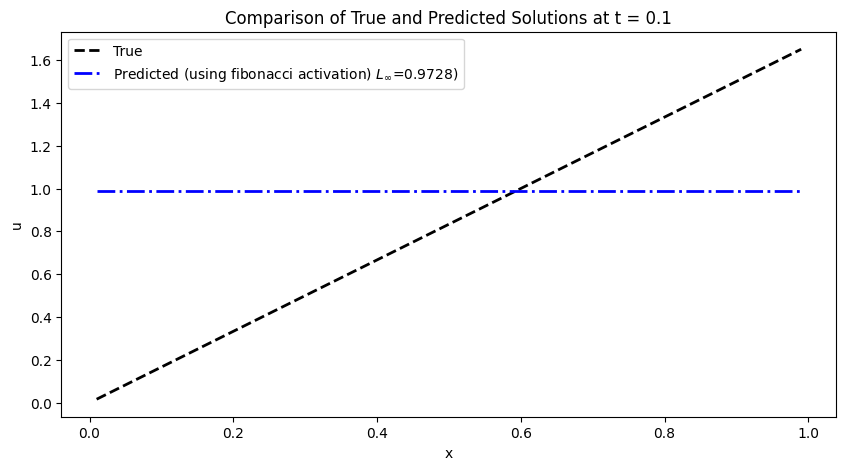

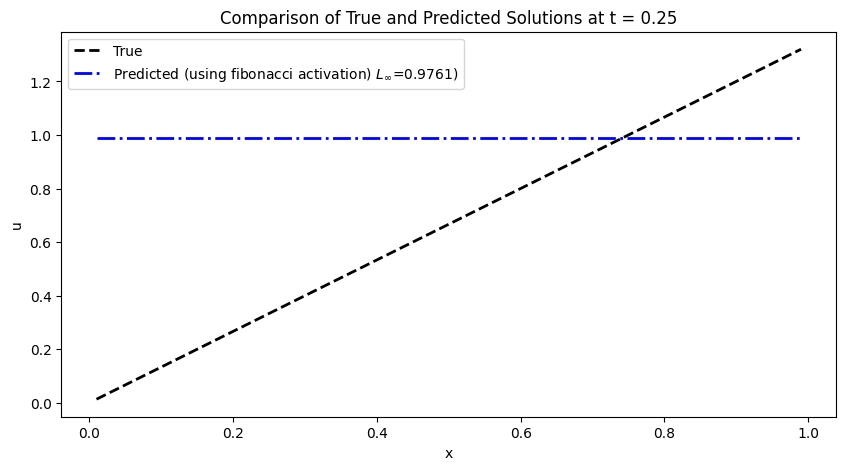

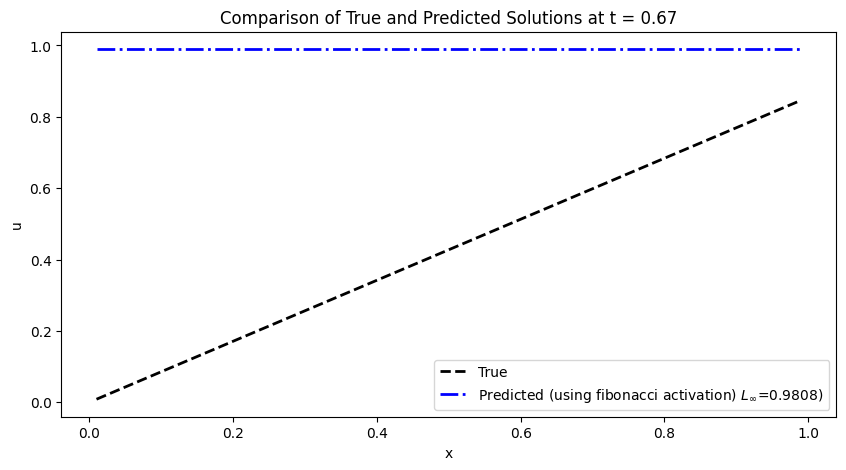

In [ ]:
def plot_results(t_values):
    for t in t_values:
        mask = np.isclose(x_test[:, 1], t)
        x_plot = x_test[mask][:, 0]
        y_true_plot = y_true[mask]
        y_pred_adaptive_plot = y_pred_adaptive[mask]

        # Calculate L_inf error
        l_inf_error = np.max(np.abs(y_true_plot - y_pred_adaptive_plot))

        plt.figure(figsize=(10, 5))
        plt.plot(x_plot, y_true_plot, label='True', linestyle="--", color="black", linewidth=2)
        plt.plot(x_plot, y_pred_adaptive_plot, label=f'Predicted (using fibonacci activation) $L_{{\infty}}$={l_inf_error:.4f})', linestyle="-.", color="blue", linewidth=2)
        plt.xlabel('x')
        plt.ylabel('u')
        plt.title(f'Comparison of True and Predicted Solutions at t = {t}')
        plt.legend()
        plt.savefig(f'burger_fa_plot_t_{t}.pdf')
        plt.show()

# Plot results for t = 0.1, 0.25, 0.67
plot_results([0.1, 0.25, 0.67])

## 2D Heat Equation

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def heat_eq_exact_solution(x, t):
    """Returns the exact solution for a given x and t (for sinusoidal initial conditions)."""
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)

def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.0)
    x_max, t_max = (L, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)

def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the exact solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

# Generate a dataset with the exact solution (if you don't have one):
gen_exact_solution()

def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx

# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)

def build_and_train_model(activation):
    net = dde.nn.FNN([2] + [20] * 3 + [1], activation, "Glorot normal")
    model = dde.Model(data, net)
    model.compile("adam", lr=0.005)
    model.train(iterations=5000)
    model.compile("L-BFGS")
    model.train()
    return model


model_adaptive = build_and_train_model(AdaptiveActivation())

# Generate test data
X, y_true = gen_testdata()

# Get predictions
y_pred_adaptive = model_adaptive.predict(X).flatten()

<ipython-input-9-6c484ddf3474>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  usol[i][j] = heat_eq_exact_solution(x[i], t[j])


Compiling model...
Building feed-forward neural network...
'build' took 0.112608 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.733635 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.25e-01, 1.05e-01, 8.51e-01]    [1.18e-01, 1.05e-01, 8.51e-01]    []  
1000      [1.22e-04, 1.05e-05, 1.48e-06]    [8.43e-05, 1.05e-05, 1.48e-06]    []  
2000      [3.19e-05, 3.25e-06, 1.06e-06]    [2.16e-05, 3.25e-06, 1.06e-06]    []  
3000      [1.91e-05, 3.22e-06, 2.18e-07]    [1.21e-05, 3.22e-06, 2.18e-07]    []  
4000      [2.99e-05, 3.73e-06, 1.04e-05]    [1.82e-05, 3.73e-06, 1.04e-05]    []  
5000      [1.23e-05, 1.85e-06, 4.32e-07]    [7.33e-06, 1.85e-06, 4.32e-07]    []  

Best model at step 5000:
  train loss: 1.46e-05
  test loss: 9.60e-06
  test metric: []

'train' took 45.835396 s

Compiling model...
'compile' took 0.579362 s

Training model...

Step      Train loss                        Test loss                         Test metric
5000      [1.23e-05, 1.85e-06, 4.32e-07]    [7.33e-06, 1.85e-06, 4.32e-07]    []  
5161      [1

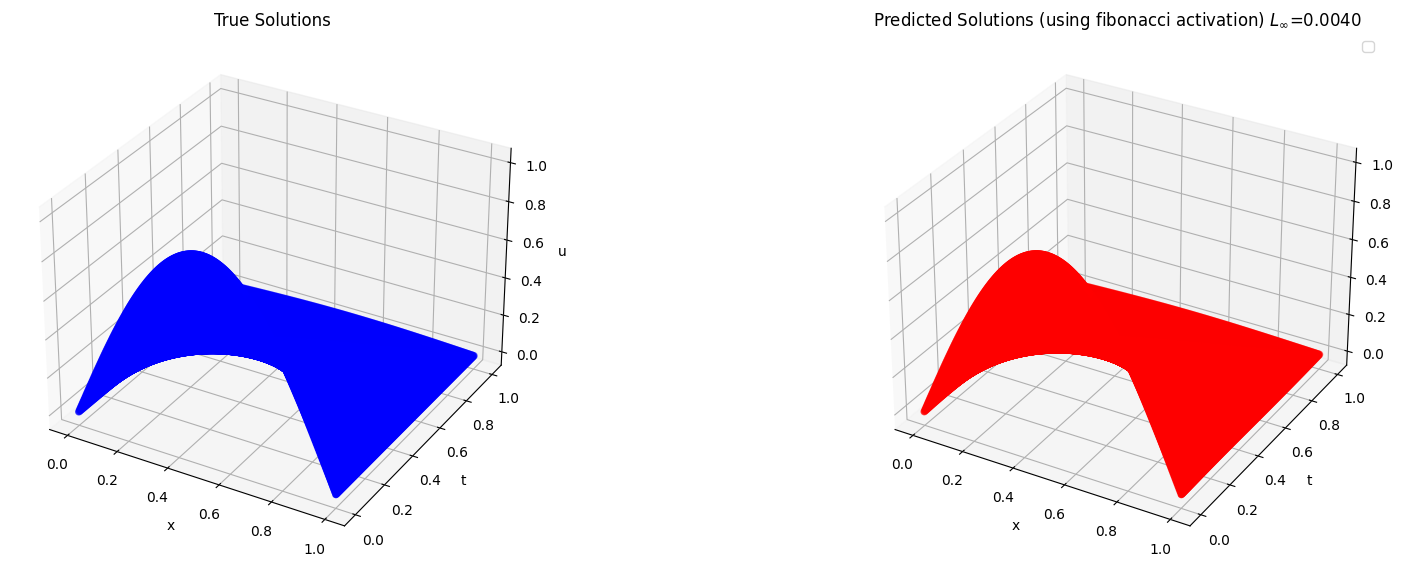

In [ ]:
def plot_3d_results(x, y_true, y_pred):
    # Calculate L_inf error
    l_inf_error = np.max(np.abs(y_true - y_pred))

    fig = plt.figure(figsize=(20, 15))

    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], y_true, c='blue', marker='o')
    ax1.set_title('True Solutions')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('u')

    ax2 = fig.add_subplot(222, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], y_pred, c='red', marker='o')
    ax2.set_title(f'Predicted Solutions (using fibonacci activation) $L_{{\infty}}$={l_inf_error:.4f}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    ax2.set_zlabel('u')

    plt.legend()
    plt.savefig('heat_fa_plot.png')
    plt.show()

plot_3d_results(X, y_true.flatten(), y_pred_adaptive)


## 2D Helmholtz Equation

In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from deepxde.backend import tf

# General parameters
n = 2
precision_train = 10
precision_test = 30
hard_constraint = True
weights = 100  # if hard_constraint == False
iterations = 5000
learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 150

# Define sine function
sin = dde.backend.sin
k0 = 2 * np.pi * n

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    if dde.backend.backend_name == "jax":
        y = y[0]
        dy_xx = dy_xx[0]
        dy_yy = dy_yy[0]

    f = k0**2 * sin(k0 * x[:, 0:1]) * sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0**2 * y - f

def func(x):
    return np.sin(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2])

def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y

def boundary(_, on_boundary):
    return on_boundary

geom = dde.geometry.Rectangle([0, 0], [1, 1])
wave_len = 1 / n

hx_train = wave_len / precision_train
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

if hard_constraint == True:
    bc = []
else:
    bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=nx_train**2,
    num_boundary=4 * nx_train,
    solution=func,
    num_test=nx_test**2,
)

# Define a sine activation function
def sine_activation(x):
    return tf.sin(x)

# Function to train the model with different activation functions
def train_model(activation):
    net = dde.nn.FNN([2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform")
    if hard_constraint == True:
        net.apply_output_transform(transform)
    model = dde.Model(data, net)
    if hard_constraint == True:
        model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
    else:
        loss_weights = [1, weights]
        model.compile("adam", lr=learning_rate, metrics=["l2 relative error"], loss_weights=loss_weights)
    model.train(iterations=iterations)
    return model

# Train model with the sine activation function
model_sine = train_model(sine_activation)

# Generate test data
x_test = data.test_x

# Predict solutions
y_true = func(x_test)
y_pred_sine = model_sine.predict(x_test)


Compiling model...
Building feed-forward neural network...
'build' took 0.091307 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.526504 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.21e+03]    [6.44e+03]    [1.00e+00]    
1000      [1.08e+02]    [1.33e+02]    [3.67e-01]    
2000      [2.01e+00]    [2.39e+00]    [4.63e-02]    
3000      [1.74e-01]    [2.15e-01]    [6.45e-03]    
4000      [5.97e-02]    [7.73e-02]    [1.65e-03]    
5000      [3.95e-02]    [5.12e-02]    [2.34e-03]    

Best model at step 5000:
  train loss: 3.95e-02
  test loss: 5.12e-02
  test metric: [2.34e-03]

'train' took 219.528729 s



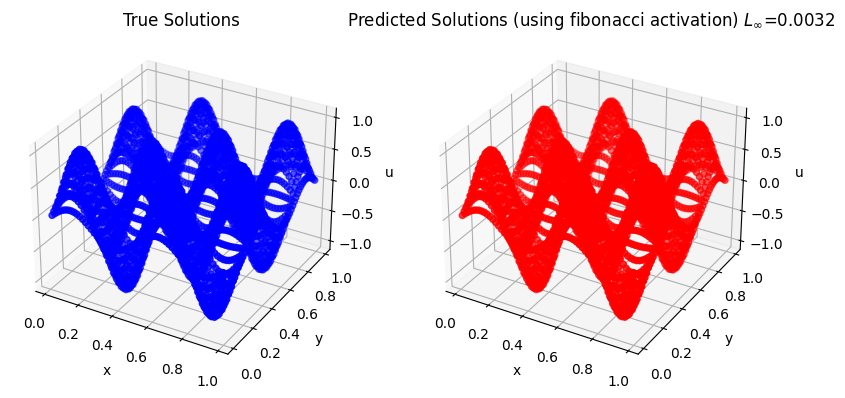

In [ ]:
def plot_3d_results(x, y_true, y_pred_sine):
    # Calculate L_inf error
    l_inf_error = np.max(np.abs(y_true - y_pred_sine))

    fig = plt.figure(figsize=(15, 10))

    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], y_true, c='blue', marker='o')
    ax1.set_title('True Solutions')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('u')

    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], y_pred_sine, c='red', marker='o')
    ax2.set_title(f'Predicted Solutions (using fibonacci activation) $L_{{\infty}}$={l_inf_error:.4f}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('u')

    plt.savefig('helmholtz_fa_plot')
    plt.show()

plot_3d_results(x_test, y_true, y_pred_sine)


## 2D Elastostatic Equation

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

lmbd = 1.0
mu = 0.5
Q = 4.0

# Define functions
sin = dde.backend.sin
cos = dde.backend.cos
stack = dde.backend.stack

geom = dde.geometry.Rectangle([0, 0], [1, 1])
BC_type = ["hard", "soft"][0]

def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1.0)

def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1.0)

def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)

# Exact solutions
def func(x):
    ux = np.cos(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    uy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4

    E_xx = -2 * np.pi * np.sin(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    E_yy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 3
    E_xy = 0.5 * (
        np.pi * np.cos(2 * np.pi * x[:, 0:1]) * np.cos(np.pi * x[:, 1:2])
        + np.pi * np.cos(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4
    )

    Sxx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    Syy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    Sxy = 2 * E_xy * mu

    return np.hstack((ux, uy, Sxx, Syy, Sxy))

# Soft Boundary Conditions
ux_top_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_top, component=0)
ux_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
uy_left_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=1)
uy_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
uy_right_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_right, component=1)
sxx_left_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=2)
sxx_right_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_right, component=2)
syy_top_bc = dde.icbc.DirichletBC(
    geom,
    lambda x: (2 * mu + lmbd) * Q * np.sin(np.pi * x[:, 0:1]),
    boundary_top,
    component=3,
)

# Hard Boundary Conditions
def hard_BC(x, f):
    Ux = f[:, 0] * x[:, 1] * (1 - x[:, 1])
    Uy = f[:, 1] * x[:, 0] * (1 - x[:, 0]) * x[:, 1]

    Sxx = f[:, 2] * x[:, 0] * (1 - x[:, 0])
    Syy = f[:, 3] * (1 - x[:, 1]) + (lmbd + 2 * mu) * Q * sin(np.pi * x[:, 0])
    Sxy = f[:, 4]
    return stack((Ux, Uy, Sxx, Syy, Sxy), axis=1)

def fx(x):
    return (
        -lmbd
        * (
            4 * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
            - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1])
        )
        - mu
        * (
            np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
            - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1])
        )
        - 8 * mu * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
    )

def fy(x):
    return (
        lmbd
        * (
            3 * Q * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
            - 2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
        )
        - mu
        * (
            2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
            + (Q * x[:, 1:2] ** 4 * np.pi**2 * sin(np.pi * x[:, 0:1])) / 4
        )
        + 6 * Q * mu * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
    )

def jacobian(f, x, i, j):
    if dde.backend.backend_name == "jax":
        return dde.grad.jacobian(f, x, i=i, j=j)[0]
    else:
        return dde.grad.jacobian(f, x, i=i, j=j)

def pde(x, f):
    E_xx = jacobian(f, x, i=0, j=0)
    E_yy = jacobian(f, x, i=1, j=1)
    E_xy = 0.5 * (jacobian(f, x, i=0, j=1) + jacobian(f, x, i=1, j=0))

    S_xx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    S_yy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    S_xy = E_xy * 2 * mu

    Sxx_x = jacobian(f, x, i=2, j=0)
    Syy_y = jacobian(f, x, i=3, j=1)
    Sxy_x = jacobian(f, x, i=4, j=0)
    Sxy_y = jacobian(f, x, i=4, j=1)

    momentum_x = Sxx_x + Sxy_y - fx(x)
    momentum_y = Sxy_x + Syy_y - fy(x)

    if dde.backend.backend_name == "jax":
        f = f[0]  # f[1] is the function used by jax to compute the gradients

    stress_x = S_xx - f[:, 2:3]
    stress_y = S_yy - f[:, 3:4]
    stress_xy = S_xy - f[:, 4:5]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]

if BC_type == "hard":
    bcs = []
else:
    bcs = [
        ux_top_bc,
        ux_bottom_bc,
        uy_left_bc,
        uy_bottom_bc,
        uy_right_bc,
        sxx_left_bc,
        sxx_right_bc,
        syy_top_bc,
    ]

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=1000,
    num_boundary=1000,
    solution=func,
    num_test=400,
)

def build_and_train_model(activation):
    layers = [2] + [50] * 7 + [5]
    net = dde.nn.PFNN(layers, activation, "Glorot uniform")
    if BC_type == "hard":
        net.apply_output_transform(hard_BC)

    model = dde.Model(data, net)
    model.compile("adam", lr=0.07, metrics=["l2 relative error"])
    model.train(iterations=5000)
    return model


# Train models with different activations and gather predictions
model_fibonacci = build_and_train_model(AdaptiveActivation())

# Generate test data
X, y_true = data.test_x, data.test_y

# Get predictions
y_pred_fibonacci = model_fibonacci.predict(X)

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.221459 s

'compile' took 4.836763 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.81e+03, 2.64e+02, 3.25e-03, 2.52e+01, 5.89e-03]    [1.78e+03, 2.61e+02, 5.31e-03, 3.53e+01, 5.59e-03]    [1.14e+00]    
1000      [1.79e+03, 2.49e+02, 3.91e-02, 4.12e+00, 2.54e+00]    [1.77e+03, 2.41e+02, 5.46e-02, 3.46e+00, 1.38e+00]    [1.04e+00]    
2000      [1.79e+03, 2.49e+02, 3.91e-02, 4.12e+00, 2.54e+00]    [1.77e+03, 2.41e+02, 5.46e-02, 3.46e+00, 1.38e+00]    [1.04e+00]    
3000      [1.79e+03, 2.50e+02, 2.63e-02, 4.18e+00, 2.40e+00]    [1.77e+03, 2.41e+02, 3.68e-02, 3.80e+00, 1.31e+00]    [1.05e+00]    
4000      [1.79e+03, 2.49e+02, 3.91e-02, 4.12e+00, 2.54e+00]    [1.77e+03, 2.41e+02, 5.46e-02, 3.46e+00, 1.38e+00]    [1.04e+00]    
5000      [1.79e+03, 2.49e+02, 3.91e-02, 4.12e+00, 2.54e+00]    [1.77e+03, 2.41e+02, 5.46e-02, 3.46e+00, 1.38e+00]    [1.04e+00]   

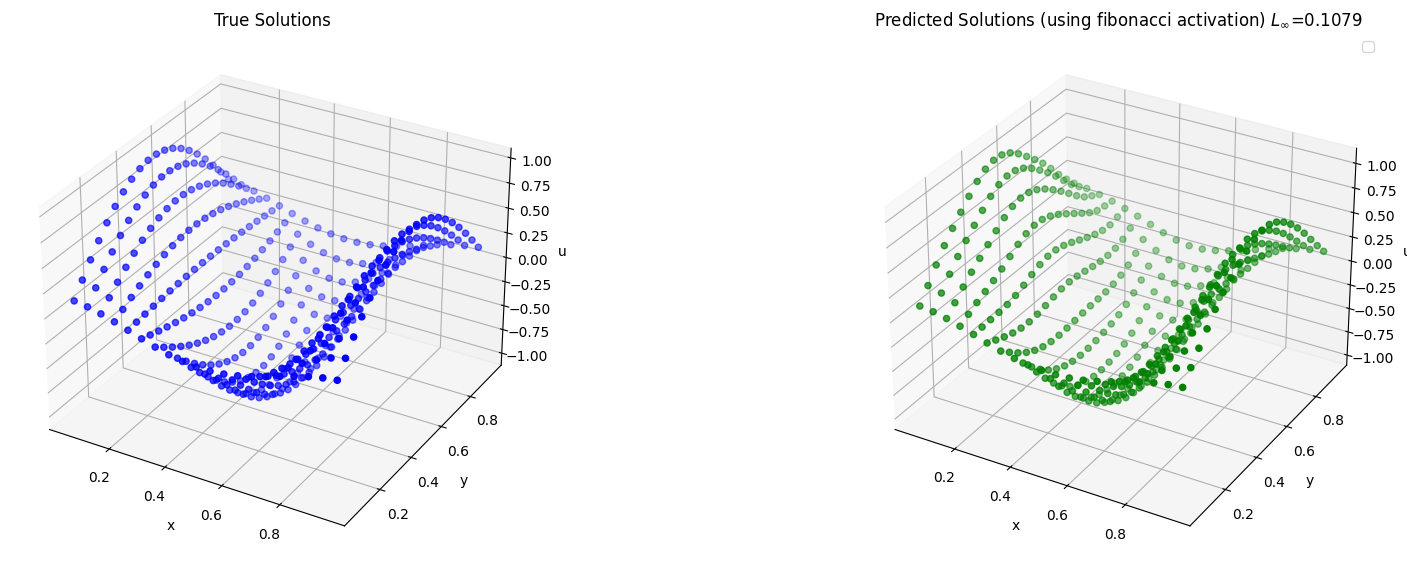

In [ ]:
def plot_3d_results(x, y_true, y_pred_fibonacci):
    # Calculate L_inf error
    l_inf_error = np.max(np.abs(y_true[:, 0] - y_pred_fibonacci[:, 0]))

    fig = plt.figure(figsize=(20, 15))

    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], y_true[:, 0], c='blue', marker='o')
    ax1.set_title('True Solutions')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('u')

    ax2 = fig.add_subplot(222, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], y_pred_fibonacci[:, 0], c='green', marker='o')
    ax2.set_title(f'Predicted Solutions (using fibonacci activation) $L_{{\infty}}$={l_inf_error:.4f}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('u')

    plt.legend()
    plt.savefig('elastostatic_fa_plot.pdf')
    plt.show()

# Plot results
plot_3d_results(X, y_true, y_pred_fibonacci)
